# Run the model on the test set

In this notebook, we run detailed tests on the highest performing model(s). We record the top N accuracies and create a confusion matrix with predictions on the test set.

In [1]:
import classifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import confusion_matrix

2025-02-13 15:11:59.368214: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
INPUT_WIDTH = 3
SEQ_LEN=180

## Load data

In [3]:
players_inputs = classifier.players_inputs('dataset/displacements')
num_players = len(players_inputs.keys())

## Testing Functions

The following code block contains functions that are used to run the tests & organize the results.

In [4]:
def get_accs(hs, ys):
    """
    Records the top N accuracies for the given predictions (`hs`) compared against the given ground-truth values (`ys`).
    """
    
    ranks = []
    for i in range(hs.shape[0]):
        rankings = np.argsort(hs[i])
        rank = (num_players-1) - np.where((rankings == np.argmax(ys[i])))[0][0]
        ranks.append(rank)
    
    topn_occurences = []
    running = 0
    for i in range(num_players):
        topn_occurences.append(ranks.count(i) + running)
        running += ranks.count(i)

    topn_acc = [t / topn_occurences[-1] for t in topn_occurences]

    return topn_acc

def test_model(model, test_x, test_y):    
    """
    Runs the model on the test set & returs the top N accuracies and the confusion matrix
    """

    # predict on the test set
    test_h = model.predict(test_x)

    # get hard predictions
    predicted = [np.argmax(test_h[i]) for i in range(len(test_h))]
    actual = [np.argmax(test_y[i]) for i in range(len(test_y))]

    # top n accuracies
    topn_acc = get_accs(test_h, test_y)
    # confusion matrix
    confusion_labels = [classifier.i_to_p[i] for i in range(len(classifier.i_to_p))]
    c_matrix = pd.DataFrame(confusion_matrix(predicted, actual, normalize='true'), columns=confusion_labels, index=confusion_labels)
    c_matrix.index.name = "Actual Class"
    c_matrix.columns.name = "Predicted Class"

    return topn_acc, c_matrix

## Test from end to end

1. Train the model
2. Run the tests as defined in `test_model`
3. Return the training history & test results

We train the model here so that we can record the learning curve.

In [5]:
def test_run(model):
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = classifier.prepare_data(players_inputs, seq_len=SEQ_LEN)

    print(f'{len(train_x)=}, {len(valid_x)=}, {len(test_x)=}')

    history = model.fit(
        train_x, train_y, epochs=80, verbose=0, batch_size=64, validation_data=(valid_x, valid_y)
    )

    # run the tests
    topn_acc, c_matrix = test_model(model, test_x, test_y)

    return history, topn_acc, c_matrix

Creating the model

In [7]:
model = classifier.createClassifier(width=3, seq_len=SEQ_LEN)
model.summary()

model.save_weights('models/untrained.weights.h5')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 87, 32)    │        704 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 178, 32)   │        320 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 265, 32)   │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elu_7 (ELU)         │ (None, 265, 32)   │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 264, 32)   │      2,080 │ elu_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 263, 32)   │      2,080 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 263, 32)   │          0 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 263, 32)   │      8,320 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │      8,320 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,352 (87.31 KB)

 Trainable params: 22,352 (87.31 KB)

 Non-trainable params: 0 (0.00 B)

Training & running the model & recording the results

In [9]:
histories = []
topns = []
c_matrices = []

# reset the model
model.load_weights('models/untrained.weights.h5')

# do a test run
h, t, c = test_run(model)

histories.append(h)
topns.append(t)
c_matrices.append(c)

len(train_x)=12111, len(valid_x)=4037, len(test_x)=4037
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


# Deal with the results

Now, we visualize and write the data from our tests.

In [10]:
# t_hists = list(zip(*histories[::-1]))
t_accs = list(zip(*topns[::-1]))

## Top N accuracies

The top 1 accuracy is the proportion of predictions where the correct answer was predicted as the most likely by our model. Top 2 accuracy is when the correct answer is one of the 2 most likely predicted by our model, and so on.

In [11]:
avg_accs = []
for n in t_accs:
    avg_accs.append(sum(n) / len(n))

print(f'{t_accs}\n{avg_accs}')

[(0.8674758484022789,), (0.9521922219469904,), (0.977953926182809,), (0.9898439435224177,), (0.9955412434976467,), (0.997275204359673,), (0.997275204359673,), (0.9985137478325489,), (0.9992568739162745,), (0.9992568739162745,), (0.9995045826108496,), (0.9995045826108496,), (1.0,), (1.0,), (1.0,), (1.0,)]
[0.8674758484022789, 0.9521922219469904, 0.977953926182809, 0.9898439435224177, 0.9955412434976467, 0.997275204359673, 0.997275204359673, 0.9985137478325489, 0.9992568739162745, 0.9992568739162745, 0.9995045826108496, 0.9995045826108496, 1.0, 1.0, 1.0, 1.0]


## Confusion matrix

The confusion matrix shows how often the model

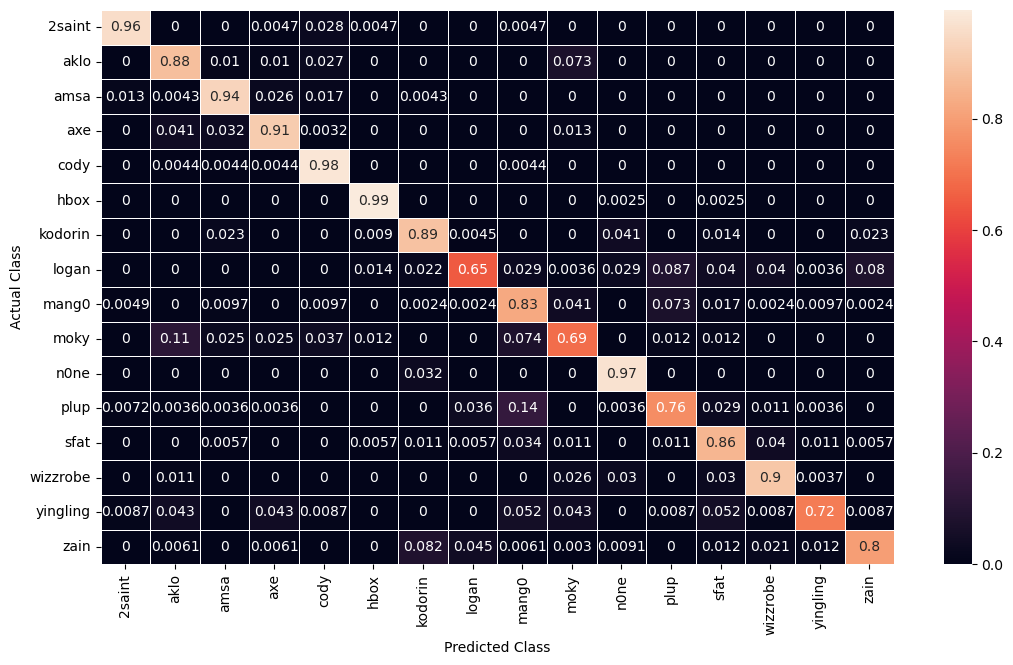

In [12]:

px = 1/plt.rcParams['figure.dpi']  # pixels per inch
plt.subplots(figsize=(1280*px, 720*px))

ax = sns.heatmap(c_matrices[0], linewidth=.6, annot=True,)
plt.savefig(f'results/180_matrix')
plt.show()

## learning curve

In [14]:
# average the histories

t_accs = np.array([[x for x in h.history['accuracy']] for h in histories])
mean_accs = np.mean(t_accs, axis=0)
v_accs = np.array([[x for x in h.history['val_accuracy']] for h in histories])
mean_val_accs = np.mean(v_accs, axis=0)
mean_val_accs.shape

avg_history = {'accuracy': histories[0].history['accuracy'], 'val_accuracy': histories[0].history['val_accuracy']}

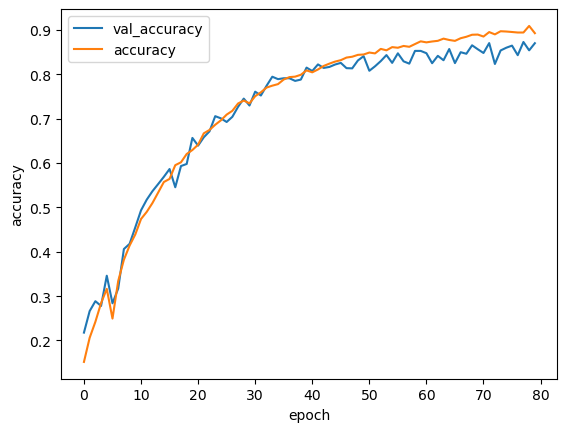

In [16]:
plt.plot('val_accuracy', data=avg_history)
plt.plot('accuracy', data=avg_history)
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

# plt.savefig(f'results/GRU_curve')
plt.show()